### Gaussian Process Classifier

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.impute import SimpleImputer
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score, precision_recall_curve, auc


In [2]:

# 读取数据
df = pd.read_csv('breast cancer.csv')
X = df.drop('diagnosis', axis=1)
y = df['diagnosis'].map({'M': 1, 'B': 0})
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# 这里使用一个基准的 RBF 核
gpc_kernel = 1.0 * RBF(1.0)
gpc = GaussianProcessClassifier(kernel=gpc_kernel, random_state=42, n_jobs=-1)
gpc.fit(X_train, y_train)

prediction_gpc = gpc.predict(X_test)
y_pred_proba_gpc = gpc.predict_proba(X_test)[:, 1] # 获取正类的预测概率



E:\anaconda\envs\pytorch\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Unnamed: 32']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [3]:

#分类报告
print("\nGaussian Process Classifier 分类报告:")
print(classification_report(y_test, prediction_gpc))
accuracy_gpc = accuracy_score(y_test, prediction_gpc)
print(f"精确度: {accuracy_gpc:.4f}")



Gaussian Process Classifier 分类报告:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        71
           1       1.00      0.95      0.98        43

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

精确度: 0.9825


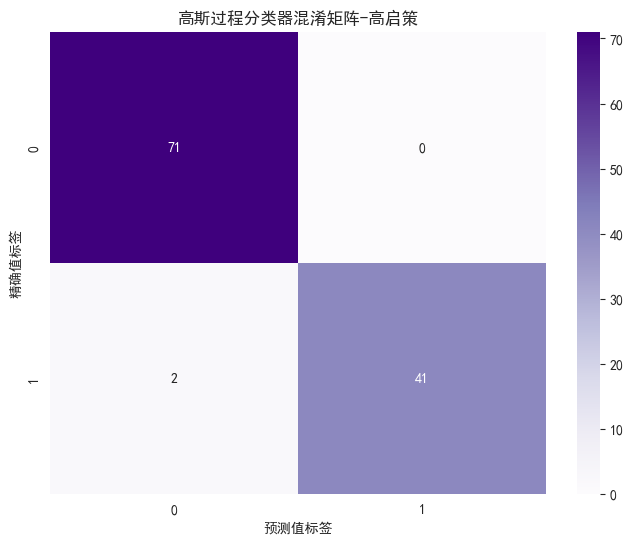

In [4]:


# 混淆矩阵可视化
os.makedirs('./picture/Gaussian Process Classifier', exist_ok=True) # 确保目录存在

cm_gpc = confusion_matrix(y_test, prediction_gpc)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gpc, annot=True, fmt='d', cmap='Purples',
            xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('预测值标签')
plt.ylabel('精确值标签')
plt.title('高斯过程分类器混淆矩阵-高启策')
plt.savefig('./picture/Gaussian Process Classifier/confusion_matrix.png')
plt.show()
plt.close()


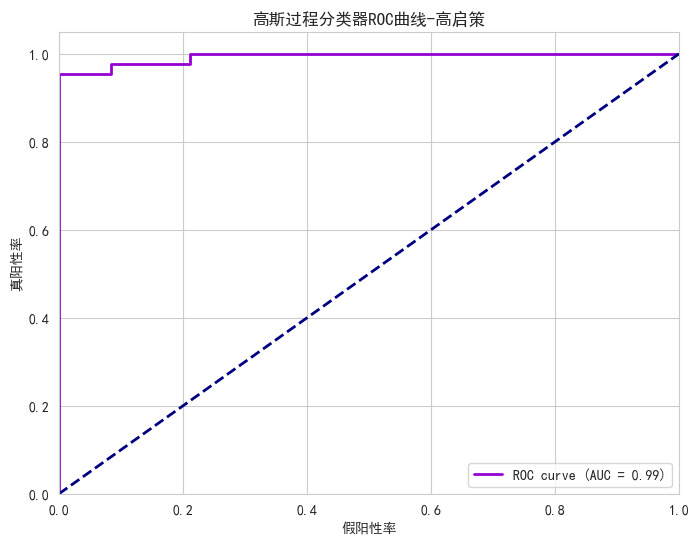


高斯过程分类器ROC曲线的AUC: 0.99


In [7]:


# ROC 曲线和 AUC 值
fpr_gpc, tpr_gpc, thresholds_gpc = roc_curve(y_test, y_pred_proba_gpc)
auc_gpc = roc_auc_score(y_test, y_pred_proba_gpc)

plt.figure(figsize=(8, 6))
plt.plot(fpr_gpc, tpr_gpc, color='darkviolet', lw=2, label=f'ROC curve (AUC = {auc_gpc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('假阳性率')
plt.ylabel('真阳性率')
plt.title('高斯过程分类器ROC曲线-高启策')
plt.legend(loc="lower right")
plt.savefig('./picture/Gaussian Process Classifier/roc_curve.png')
plt.show()
plt.close()
print(f"\n高斯过程分类器ROC曲线的AUC: {auc_gpc:.2f}")


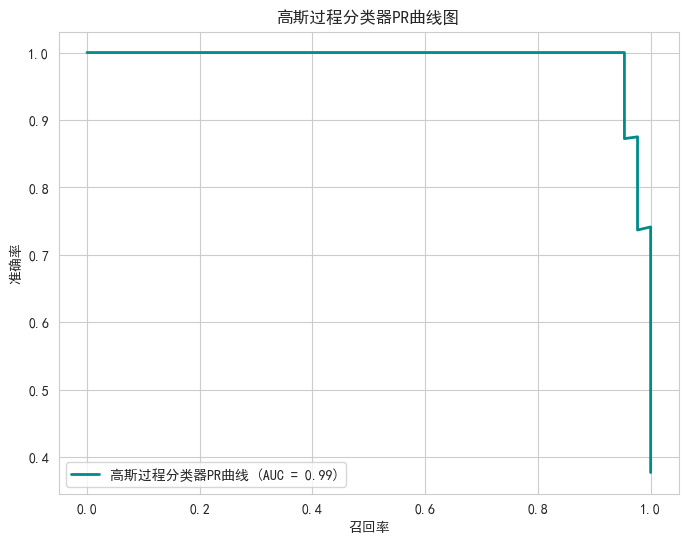


高斯过程分类器PR曲线图的AUC: 0.99


In [8]:


# PR 曲线
precision_gpc, recall_gpc, _ = precision_recall_curve(y_test, y_pred_proba_gpc)
auc_pr_gpc = auc(recall_gpc, precision_gpc)

plt.figure(figsize=(8, 6))
plt.plot(recall_gpc, precision_gpc, color='darkcyan', lw=2, label=f'高斯过程分类器PR曲线 (AUC = {auc_pr_gpc:.2f})')
plt.xlabel('召回率')
plt.ylabel('准确率')
plt.title('高斯过程分类器PR曲线图')
plt.legend(loc="lower left")
plt.savefig('./picture/Gaussian Process Classifier/pr_curve.png')
plt.show()
plt.close()
print(f"\n高斯过程分类器PR曲线图的AUC: {auc_pr_gpc:.2f}")



In [9]:

performance_metrics_gpc = {
    'Model': 'Gaussian Process Classifier',
    'Accuracy': accuracy_gpc,
    'Precision': precision_score(y_test, prediction_gpc),
    'Recall': recall_score(y_test, prediction_gpc),
    'F1 Score': f1_score(y_test, prediction_gpc),
    'AUC-ROC': auc_gpc,
    'AUC-PR': auc_pr_gpc 
}
with open('./picture/Gaussian Process Classifier/performance_metrics.txt', 'w') as f:
    for metric, value in performance_metrics_gpc.items():
        if isinstance(value, float):
            f.write(f"{metric}: {value:.4f}\n")
        else:
            f.write(f"{metric}: {value}\n")


### Stacking

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4" 


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score, 
                             roc_curve, roc_auc_score, precision_score, recall_score, 
                             f1_score, precision_recall_curve, auc)

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


In [11]:

# 读取数据
df = pd.read_csv('breast cancer.csv')

# 数据预处理
X = df.drop('diagnosis', axis=1)
y = df['diagnosis'].map({'M': 1, 'B': 0})

# 缺失值处理
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# 标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# 拆分数据
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


E:\anaconda\envs\pytorch\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Unnamed: 32']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [12]:

# 构建基础学习器
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('svm', SVC(probability=True, kernel='rbf', random_state=42))
]

# 元学习器
meta_learner = LogisticRegression()

# 构建 Stacking 模型
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,
    n_jobs=-1
)

# 模型训练
stacking_clf.fit(X_train, y_train)

# 预测
y_pred_stacking = stacking_clf.predict(X_test)
y_pred_proba_stacking = stacking_clf.predict_proba(X_test)[:, 1]


In [13]:

# 输出分类报告
print("\nStacking 模型分类报告:")
print(classification_report(y_test, y_pred_stacking))
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
print(f"精确度: {accuracy_stacking:.4f}")



Stacking 模型分类报告:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        71
           1       0.95      0.95      0.95        43

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114

精确度: 0.9649


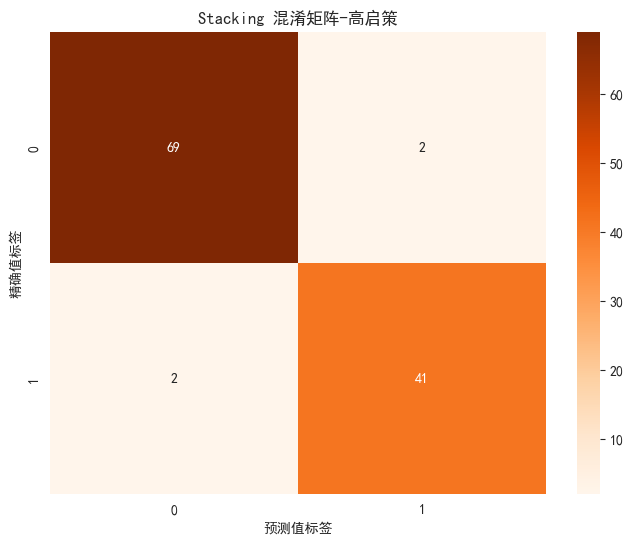

In [14]:

# 目录创建

os.makedirs('./picture/Stacking', exist_ok=True)
os.environ["LOKY_MAX_CPU_COUNT"] = str(os.cpu_count())

# 混淆矩阵可视化
cm_stacking = confusion_matrix(y_test, y_pred_stacking)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_stacking, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('预测值标签')
plt.ylabel('精确值标签')
plt.title('Stacking 混淆矩阵-高启策')
plt.savefig('./picture/Stacking/confusion_matrix.png')
plt.show()
plt.close()


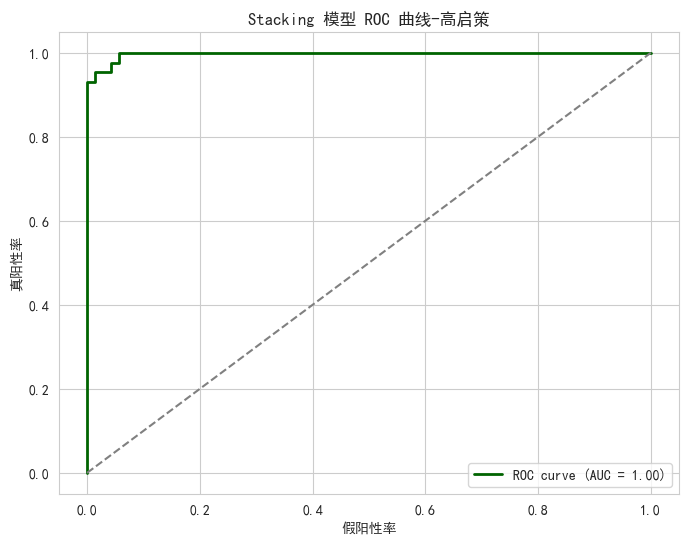

In [15]:

# ROC 曲线 & AUC
fpr_stack, tpr_stack, _ = roc_curve(y_test, y_pred_proba_stacking)
auc_stack = roc_auc_score(y_test, y_pred_proba_stacking)

plt.figure(figsize=(8, 6))
plt.plot(fpr_stack, tpr_stack, color='darkgreen', lw=2, label=f'ROC curve (AUC = {auc_stack:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('假阳性率')
plt.ylabel('真阳性率')
plt.title('Stacking 模型 ROC 曲线-高启策')
plt.legend(loc="lower right")
plt.savefig('./picture/Stacking/roc_curve.png')
plt.show()
plt.close()


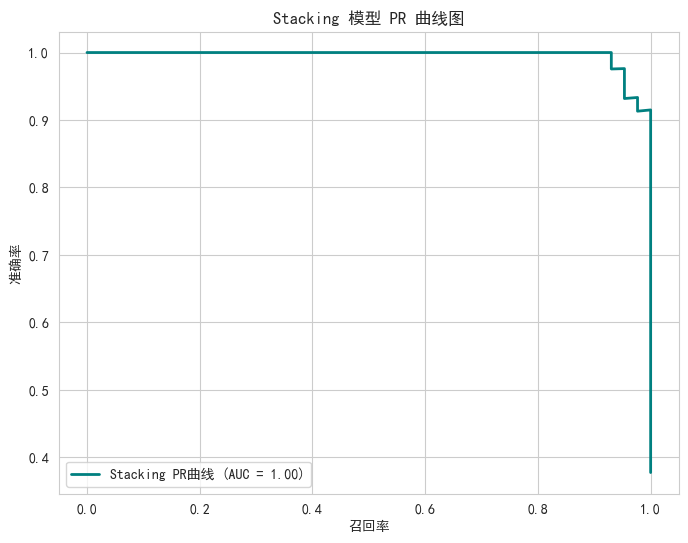


Stacking 模型 ROC AUC: 1.00
Stacking 模型 PR AUC: 1.00


In [16]:

# PR 曲线
precision_stack, recall_stack, _ = precision_recall_curve(y_test, y_pred_proba_stacking)
auc_pr_stack = auc(recall_stack, precision_stack)

plt.figure(figsize=(8, 6))
plt.plot(recall_stack, precision_stack, color='teal', lw=2, label=f'Stacking PR曲线 (AUC = {auc_pr_stack:.2f})')
plt.xlabel('召回率')
plt.ylabel('准确率')
plt.title('Stacking 模型 PR 曲线图')
plt.legend(loc="lower left")
plt.savefig('./picture/Stacking/pr_curve.png')
plt.show()
plt.close()

print(f"\nStacking 模型 ROC AUC: {auc_stack:.2f}")
print(f"Stacking 模型 PR AUC: {auc_pr_stack:.2f}")

# 保存性能指标
performance_metrics_stack = {
    'Model': 'Stacking Classifier',
    'Accuracy': accuracy_stacking,
    'Precision': precision_score(y_test, y_pred_stacking),
    'Recall': recall_score(y_test, y_pred_stacking),
    'F1 Score': f1_score(y_test, y_pred_stacking),
    'AUC-ROC': auc_stack,
    'AUC-PR': auc_pr_stack
}

with open('./picture/Stacking/performance_metrics.txt', 'w') as f:
    for metric, value in performance_metrics_stack.items():
        try:
            f.write(f"{metric}: {float(value):.4f}\n")
        except ValueError:
            f.write(f"{metric}: {value}\n")
